In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
from matplotlib import rcParams

from statsmodels.graphics import tsaplots
import statsmodels.api as sm

In [2]:
data = pd.read_csv('ECONOMICS_USCSHPIMM, 1M.csv')

In [3]:
data.head()

,time,close
0,949363200,0.8
1,951868800,1.2
2,954547200,1.5
3,957139200,1.6
4,959817600,1.5


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    294 non-null    int64  
 1   close   294 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 4.7 KB


In [5]:
data.columns

Index(['time', 'close'], dtype='object')

In [6]:
data = data.drop('time',axis=1)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   294 non-null    float64
dtypes: float64(1)
memory usage: 2.4 KB


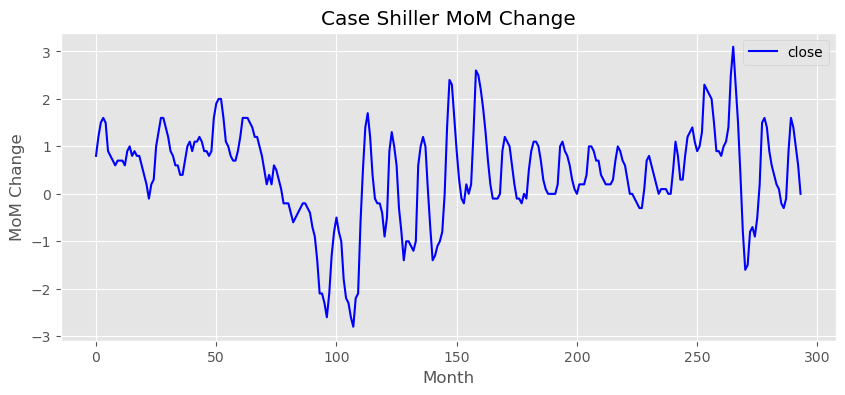

In [8]:
data.plot(figsize=(10, 4),color='blue')
plt.xlabel("Month")
plt.ylabel('MoM Change')
plt.title("Case Shiller MoM Change")
plt.show()

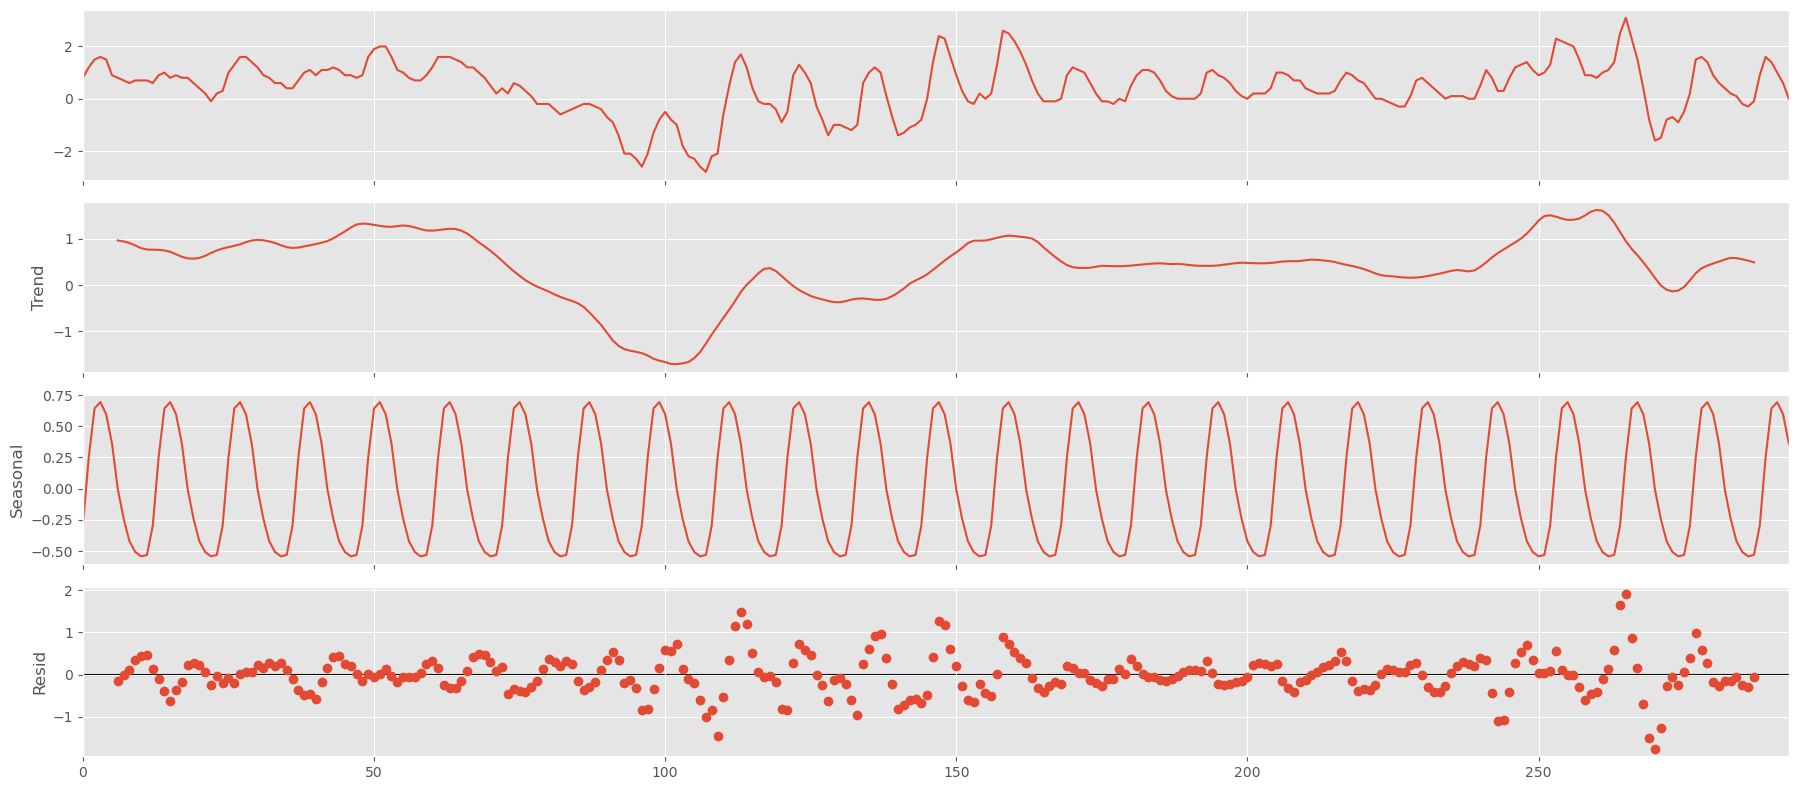

In [9]:
# Time-series decomposition
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(data, model='additive', period = 12)
fig = decomposition.plot()
plt.show()

In [10]:
data_raw = data.to_numpy()

In [11]:
# Normalize data to zero mean and unit variance
# scaler = StandardScaler()
# scaler = QuantileTransformer(output_distribution='normal')
scaler = PowerTransformer()

data_scaled = scaler.fit_transform(data_raw)

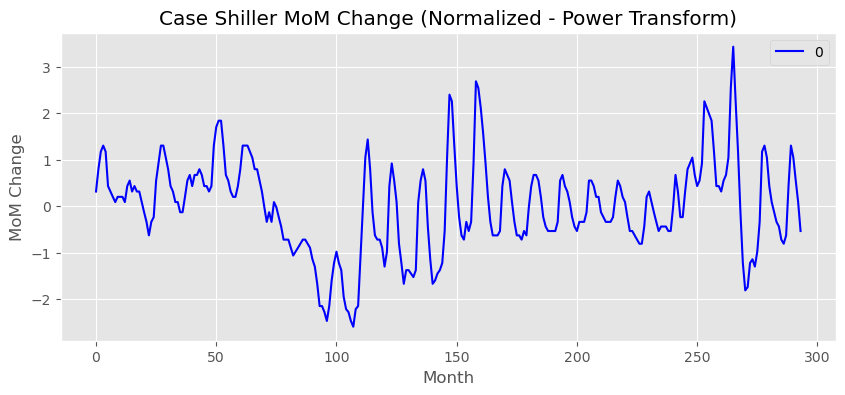

In [12]:
pd.DataFrame(data_scaled).plot(figsize=(10, 4),color='blue')
plt.xlabel("Month")
plt.ylabel('MoM Change')
plt.title("Case Shiller MoM Change (Normalized - Power Transform)")
plt.show()

In [13]:
data_scaled.shape

(294, 1)

In [14]:
# Split data using 70/30 train/test split
split = round(len(data)*.7)
number_targets = len(data) - split
data_targets = data.to_numpy()[split:]


train_data = data_scaled[:split]
test_data = data_scaled[split:]
print(train_data.shape)
print(test_data.shape)

(206, 1)
(88, 1)


In [30]:
# Parameters
n_input = number_targets
n_features = 1
batch_size = 10
epochs = 200

# Convert training data into sequences (sliding windows) needed for LSTM. each sequence of 12 the target is the next value, i.e. 13th.
def create_sequences(data, n_input):
    sequences = []
    for i in range(len(data) - n_input):
        seq = data[i:i + n_input]
        label = data[i + n_input]
        sequences.append((seq, label))
    return sequences

train_sequences = create_sequences(train_data, n_input)

# Convert to PyTorch tensors
train_x = torch.tensor([seq[0] for seq in train_sequences], dtype=torch.float32)
train_y = torch.tensor([seq[1] for seq in train_sequences], dtype=torch.float32)

## Create the model and train it - Vanilla LSTM

In [16]:
print(train_x.shape)
print(train_y.shape)

torch.Size([118, 88, 1])
torch.Size([118, 1])


In [20]:
# Dataset and DataLoader
train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

# LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, n_input, n_features):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=50, batch_first=True)
        self.dropout = nn.Dropout(p=0.2)  # Dropout layer with a probability of 0.2
        self.fc1 = nn.Linear(50, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = self.dropout(lstm_out)  # Apply dropout
        x = torch.relu(self.fc1(lstm_out[:, -1, :]))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [17]:
# Train the model
def train_model(model, train_loader, epochs):
    model.train()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(x_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
        if (epoch + 1) % 25 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

In [98]:
# Make future predictions - run just once
# Initialize and train the model
model = LSTMModel(n_input, n_features)
train_model(model, train_loader, epochs)

model.eval()
pred_list = []
batch = train_data[-n_input:].reshape((1, n_input, n_features))
batch = torch.tensor(batch, dtype=torch.float32)

with torch.no_grad():
    for i in range(n_input):
        pred = model(batch).item()
        pred_list.append(pred)
        batch = torch.cat((batch[:, 1:, :], torch.tensor([[[pred]]], dtype=torch.float32)), dim=1)

# Inverse transform the predictions
predicted_sales = scaler.inverse_transform(np.array(pred_list).reshape(-1, 1))

# Create a dataframe for predictions
df_predict = pd.DataFrame(predicted_sales, index=data[-n_input:].index, columns=['Prediction'])
print(df_predict)

Epoch [25/150], Loss: 0.0579
Epoch [50/150], Loss: 0.0290
Epoch [75/150], Loss: 0.0418
Epoch [100/150], Loss: 0.0291
Epoch [125/150], Loss: 0.0392
Epoch [150/150], Loss: 0.0286
     Prediction
206    1.059213
207    0.957807
208    0.777595
209    0.445629
210    0.138564
..          ...
289   -3.933375
290   -3.432470
291   -2.905565
292   -2.325318
293   -1.724847

[88 rows x 1 columns]


In [18]:
def reset_weights(model):
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

In [31]:
# Averaging over multiple runs (to keep the loop structure like in the original code)
n_runs = 3
store = np.zeros((n_input, n_runs))
model = LSTMModel(n_input, n_features)

for i in range(n_runs):
    #reset_weights(model)  # Reset the weights to random
    model = LSTMModel(n_input, n_features)
    train_model(model, train_loader, epochs)
    pred_list = []

    batch = train_data[-n_input:].reshape((1, n_input, n_features))
    batch = torch.tensor(batch, dtype=torch.float32)

    with torch.no_grad():
        for j in range(n_input):
            pred = model(batch).item()
            pred_list.append(pred)
            batch = torch.cat((batch[:, 1:, :], torch.tensor([[[pred]]], dtype=torch.float32)), dim=1)

    store[:, i] = scaler.inverse_transform(np.array(pred_list).reshape(-1, 1)).flatten()

# Averaging predictions
final_vanilla = np.mean(store, axis=1)

Epoch [25/200], Loss: 0.0450
Epoch [50/200], Loss: 0.0278
Epoch [75/200], Loss: 0.0379
Epoch [100/200], Loss: 0.0340
Epoch [125/200], Loss: 0.0329
Epoch [150/200], Loss: 0.0277
Epoch [175/200], Loss: 0.0179
Epoch [200/200], Loss: 0.0154
Epoch [25/200], Loss: 0.0394
Epoch [50/200], Loss: 0.0373
Epoch [75/200], Loss: 0.0589
Epoch [100/200], Loss: 0.0491
Epoch [125/200], Loss: 0.0238
Epoch [150/200], Loss: 0.0220
Epoch [175/200], Loss: 0.0116
Epoch [200/200], Loss: 0.0293
Epoch [25/200], Loss: 0.0409
Epoch [50/200], Loss: 0.0791
Epoch [75/200], Loss: 0.0571
Epoch [100/200], Loss: 0.0379
Epoch [125/200], Loss: 0.0139
Epoch [150/200], Loss: 0.0299
Epoch [175/200], Loss: 0.0253
Epoch [200/200], Loss: 0.0161


In [32]:
print(final_vanilla.shape)
print(final_vanilla)

(88,)
[ 1.13444354  1.0750987   0.92373734  0.64341177  0.36335803  0.1579215
  0.05108119  0.02548117  0.0225466   0.09404227  0.39772477  0.77531337
  0.99188294  1.00820457  0.88585369  0.60865488  0.27582721 -0.04754445
 -0.1776098  -0.25733981 -0.27957252 -0.31780661  0.01855189  0.3095118
  0.68752688  0.7404392   0.51143953  0.14846953 -0.38471131 -0.8557922
 -1.06720547 -1.36363064 -1.24259339 -1.18838149 -0.9391449  -0.57409187
 -0.11627599  0.34051859  0.59678601  0.6025543   0.49339057  0.20021083
  0.03937254 -0.17493733 -0.24585534  0.00148156  0.43649524  0.46556601
  0.64791346  0.92194631  0.87316513  0.53587013  0.18569635 -0.19577774
 -0.33190989 -0.57867394 -0.64644371 -0.28225812  0.08495785  0.34818243
  0.49823428  0.76453794  0.58870631  0.27113707 -0.01303306 -0.36931671
 -0.58543003 -0.85829265 -0.77999647 -0.42623955  0.25156159  0.26654078
  0.46194664  0.69609735  0.46747725  0.12417619 -0.16566353 -0.41432068
 -0.68583221 -0.81556995 -0.57997217 -0.09166076

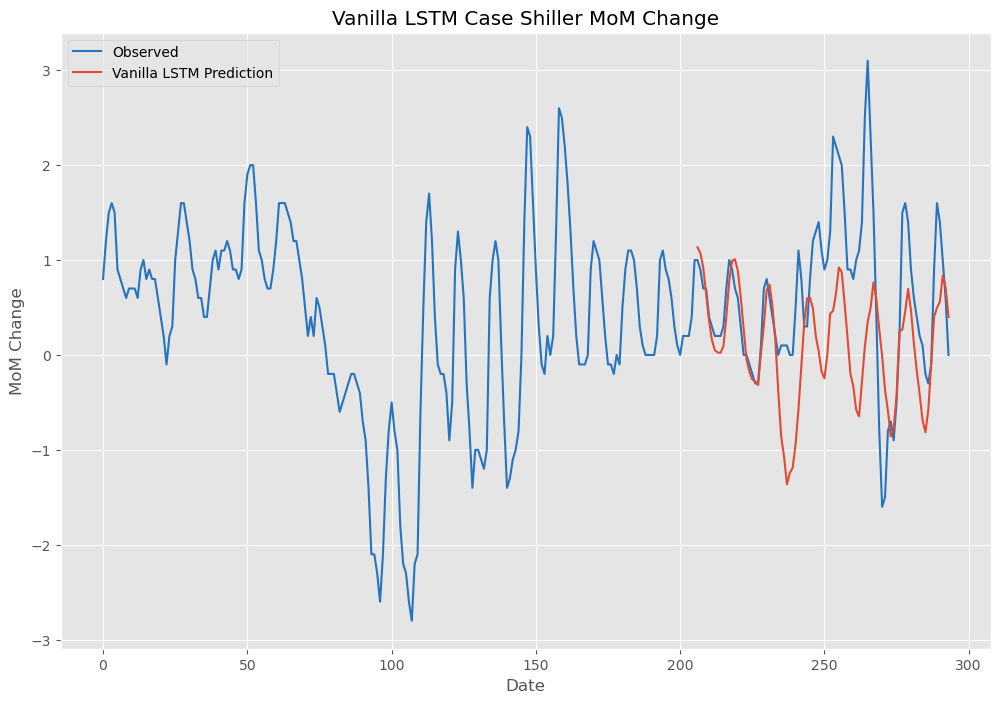

In [33]:
# report performance
rcParams['figure.figsize'] = 12, 8
# line plot of observed vs predicted
plt.plot(data.index,data,label="Observed",color='#2574BF')
plt.plot(data[split:].index,final_vanilla,label="Vanilla LSTM Prediction")
plt.title('Vanilla LSTM Case Shiller MoM Change')
plt.xlabel('Date')
plt.ylabel('MoM Change')
plt.legend()
plt.show()

In [24]:
def performance(y_true, y_pred): 
    mse = ((y_pred - y_true) ** 2).mean()
    mape= np.mean(np.abs((y_true - y_pred) / (y_true+0.001))) * 100
    performance_data= {'MSE':round(mse, 2),
                      'RMSE':round(np.sqrt(mse), 2),
                       'MAPE':round(mape, 2)
                      }
    return performance_data

In [34]:
vanilla_lstm = performance(data_targets,final_vanilla)
vanilla_lstm

{'MSE': 1.29, 'RMSE': 1.14, 'MAPE': 3511.95}

## Stacked LSTM


In [26]:
# Define the stacked LSTM model
class StackedLSTMModel(nn.Module):
    def __init__(self, n_input, n_features):
        super(StackedLSTMModel, self).__init__()
        # First LSTM layer (returns entire sequences)
        self.lstm1 = nn.LSTM(input_size=n_features, hidden_size=50, batch_first=True, dropout=0.25 ,num_layers=2)
        # Second LSTM layer (returns entire sequences)
        self.lstm2 = nn.LSTM(input_size=50, hidden_size=50, batch_first=True)
        #manual dropout
        self.dropout = nn.Dropout(0.2)
        # Fully connected layers
        self.fc1 = nn.Linear(50, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 1)

    def forward(self, x):
        lstm_out1, _ = self.lstm1(x)
        lstm_out2, _ = self.lstm2(lstm_out1)
        x = lstm_out2[:, -1, :]  # Get the last time step output
        #x = self.dropout(x)  # Apply dropout here
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [35]:
# Train and predict multiple times
n_runs = 3
store2 = np.zeros((number_targets, n_runs))

for i in range(n_runs):
    # Initialize the model
    model_stacked = StackedLSTMModel(n_input=n_input, n_features=n_features)
    
    # Train the model
    train_model(model_stacked, train_loader, epochs)
    
    # Make predictions
    pred_list_s = []
    batch = train_data[-n_input:].reshape((1, n_input, n_features))
    batch = torch.tensor(batch, dtype=torch.float32)

    with torch.no_grad():
        for j in range(n_input):
            pred = model_stacked(batch).item()  # Get prediction
            pred_list_s.append(pred)
            # Update the batch by appending the predicted value
            batch = torch.cat((batch[:, 1:, :], torch.tensor([[[pred]]], dtype=torch.float32)), dim=1)

    # Inverse transform the predictions and store them
    store2[:, i] = scaler.inverse_transform(np.array(pred_list_s).reshape(-1, 1)).flatten()

# Average the results across runs (if needed)
final_stacked = np.mean(store2, axis=1)
print(final_stacked)

Epoch [25/200], Loss: 0.1173
Epoch [50/200], Loss: 0.0715
Epoch [75/200], Loss: 0.0286
Epoch [100/200], Loss: 0.0445
Epoch [125/200], Loss: 0.0367
Epoch [150/200], Loss: 0.0209
Epoch [175/200], Loss: 0.0170
Epoch [200/200], Loss: 0.0134
Epoch [25/200], Loss: 0.0978
Epoch [50/200], Loss: 0.0260
Epoch [75/200], Loss: 0.0295
Epoch [100/200], Loss: 0.0205
Epoch [125/200], Loss: 0.0151
Epoch [150/200], Loss: 0.0195
Epoch [175/200], Loss: 0.0104
Epoch [200/200], Loss: 0.0051
Epoch [25/200], Loss: 0.1970
Epoch [50/200], Loss: 0.0643
Epoch [75/200], Loss: 0.0633
Epoch [100/200], Loss: 0.0295
Epoch [125/200], Loss: 0.0258
Epoch [150/200], Loss: 0.0097
Epoch [175/200], Loss: 0.0050
Epoch [200/200], Loss: 0.0082
[1.03225087 0.98941951 0.86636757 0.62562805 0.31570017 0.14301751
 0.08700126 0.10507576 0.09666297 0.14613236 0.43968441 0.90944112
 1.01997468 0.97443435 0.81715493 0.57280438 0.27606669 0.09865476
 0.0785194  0.08833026 0.10524609 0.1643718  0.42030106 0.88792675
 1.0226713  0.9633656

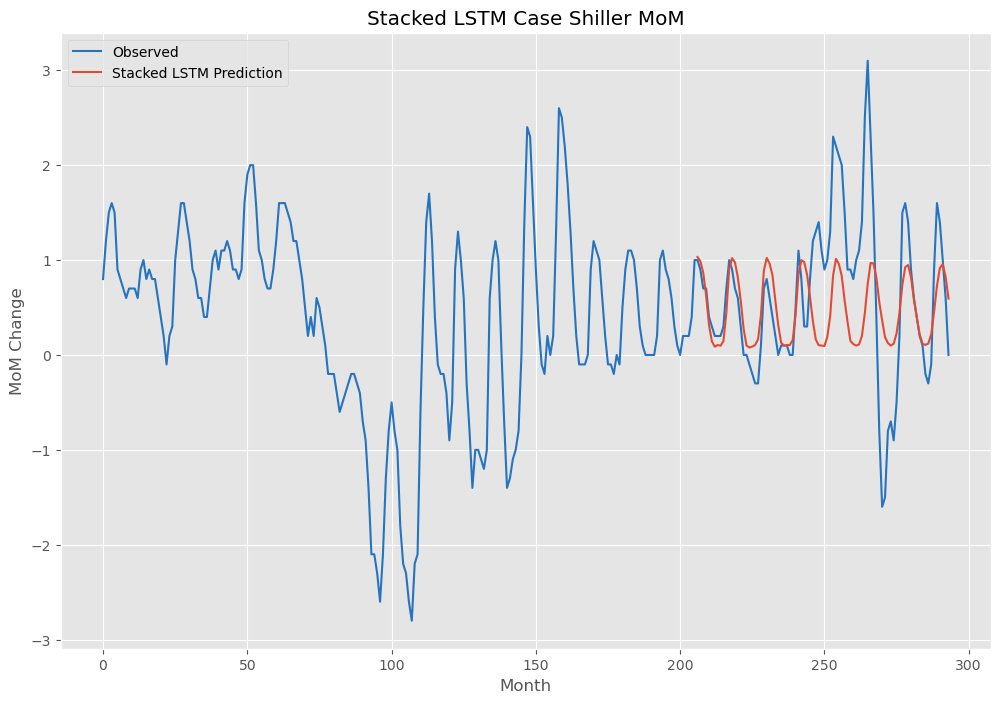

In [36]:
plt.plot(data.index,data,label="Observed",color='#2574BF')
plt.plot(data[split:].index,final_stacked,label="Stacked LSTM Prediction")
plt.title('Stacked LSTM Case Shiller MoM')
plt.xlabel('Month')
plt.ylabel('MoM Change')
plt.legend()
plt.show()

In [37]:
stacked_lstm= performance(data_targets,final_stacked)
stacked_lstm

{'MSE': 0.83, 'RMSE': 0.91, 'MAPE': 3421.48}